# Sentiment Analysis via Attention Based Models

This project will explore using attention model to perform sentiment analysis on labeled tweets. I will be implementing a modified version of the attention model from the research paper [Attention Is All You Need.](https://arxiv.org/abs/1706.03762) The dataset I am using is the [Sentiment140](https://www.kaggle.com/datasets/kazanova/sentiment140) dataset which contains about 1.6 million tweets. I will also be using the pretrained 300-dimensional [GloVe embeddings.](https://github.com/stanfordnlp/GloVe)

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
import re
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('dataset.csv', encoding='ISO-8859-1', names=["target", "ids", "date", "flag", "user", "text"])

In [3]:
dataset = np.asarray([df['target'], df['text']])

In [4]:
del df

In [5]:
dataset = dataset.T

# EDA and Data Cleaning

I start with some basic EDA and data cleaning. For EDA I plot a few visuals to get a better idea of the data I am working with, aswell as listing out some of the tweets. For data cleaning I am lower-casing each tweet and replacing some common patterns with a token. For example I am replacing Twitter hashtags with a generic 'hashtag' token.

In [6]:
positive, negative = 0, 0
for i in range(len(dataset)):
    if dataset[i][0] == 0:
        negative += 1
    else:
        positive += 1

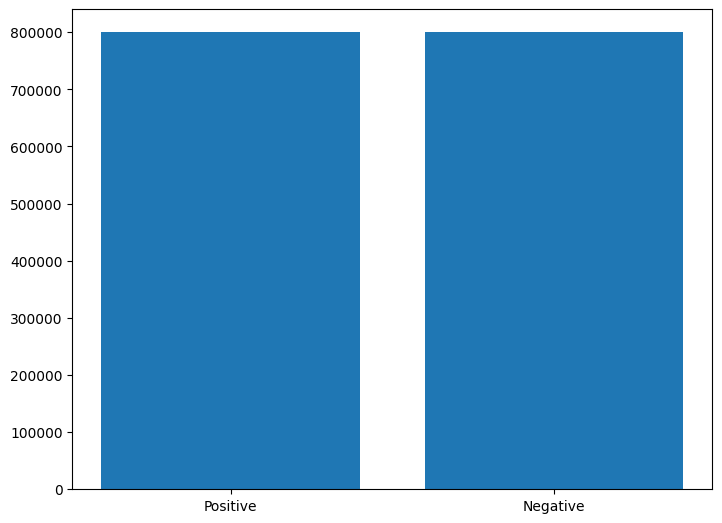

In [7]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
l = ['Positive', 'Negative']
v = [positive, negative]
ax.bar(l,v)
plt.show()

In [8]:
def missing_words(data):
    missing_words = 0
    all_words = 0
    for example in data:
        for word in example.split():
            all_words += 1
            if word not in word_to_index.keys():
                missing_words += 1
    return missing_words, all_words

In [9]:
def clean_data(data):
    for i in range(len(data)):
        tweet = data[i]
        
        urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
        userPattern       = '@[^\s]+'
        hashPattern       = '#[^\s]+'
        alphaPattern      = "[^a-zA-Z0-9]"
        numberPattern      = "[0-9]"

        tweet = tweet.lower()
        #Replace URl's with 'url'
        tweet = re.sub(urlPattern, 'URL', tweet)

        #Replace @USERNAME with 'user'
        tweet = re.sub(userPattern, 'user', tweet)
        tweet = re.sub(hashPattern, 'hashtag', tweet)

        #Remove all non alphabet characters
        tweet = re.sub(alphaPattern, ' ', tweet)
        tweet = re.sub(numberPattern, 'number', tweet)
        
        data[i] = tweet
    return data

In [10]:
clean_data(dataset[:, 1])

array(['user URL   awww  that s a bummer   you shoulda got david carr of third day to do it   d',
       'is upset that he can t update his facebook by texting it    and might cry as a result  school today also  blah ',
       'user i dived many times for the ball  managed to save numbernumber   the rest go out of bounds',
       ..., 'are you ready for your mojo makeover  ask me for details ',
       'happy numbernumberth birthday to my boo of alll time    tupac amaru shakur ',
       'happy hashtag user user user '], dtype=object)

In [11]:
#miss, al = missing_words(dataset[:, 1])

# Data Preparation

Here I load in the GloVe word embeddings and create an embedding matrix. I then define a function for converting each word in the dataset into its position into the embedding matrix. I then pad each sequence to be the same length.

In [12]:
def get_vocab(data):
    words = set()
    for example in data:
        for word in example.split():
            words.add(word)
    return words

In [13]:
vocab = get_vocab(dataset[:, 1])

In [14]:
def read_glove_vecs(glove_file):
    with open(glove_file, 'r', encoding="utf8") as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            if curr_word not in vocab:
                continue
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        embedding_matrix = []
        embedding_matrix.append(np.zeros((300)))
        words_to_index['<zero_array>'] = 0
        index_to_words[0] = '<zero_array>'
        for w in sorted(words):
            embedding_matrix.append(word_to_vec_map[w])
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    
    return words_to_index, index_to_words, word_to_vec_map, embedding_matrix

In [15]:
word_to_index, index_to_word, word_to_vec, embedding_matrix = read_glove_vecs('glove.6B.300d.txt')

In [16]:
embedding_matrix = np.asarray(embedding_matrix)

In [17]:
def string_to_token(string):
    out = []
    for word in string.split():
        if word in word_to_index.keys():
            out.append(word_to_index[word])
    return out

In [18]:
for i in range(len(dataset[:, 1])):
    dataset[i, 1] = string_to_token(dataset[i, 1])

In [19]:
dataset[:, 1]

array([list([87823, 5313, 83012, 71268, 1, 11253, 93112, 74954, 33605, 20152, 12877, 58352, 83216, 20192, 84039, 22952, 41277, 19577]),
       list([41116, 87666, 83012, 36175, 12257, 81263, 87590, 37240, 27804, 11699, 82915, 41277, 2848, 52767, 18994, 4292, 1, 69188, 72704, 84099, 2292, 8587]),
       list([87823, 38807, 22789, 50342, 83744, 30174, 83031, 5914, 50065, 84039, 72323, 83031, 69129, 33210, 59528, 58352, 9824]),
       ...,
       list([3892, 93112, 67412, 30174, 93140, 53835, 49833, 4424, 51629, 30174, 21507]),
       list([35595, 8358, 84039, 55369, 9456, 58352, 83726, 85895, 2443, 74184]),
       list([35595, 35883, 87823, 87823, 87823])], dtype=object)

In [20]:
max_len = 0
tweet_lens = []
for i in range(len(dataset[:, 1])):
    tweet_lens.append(len(dataset[i, 1]))
    if len(dataset[i, 1]) > max_len:
        max_len = len(dataset[i, 1])

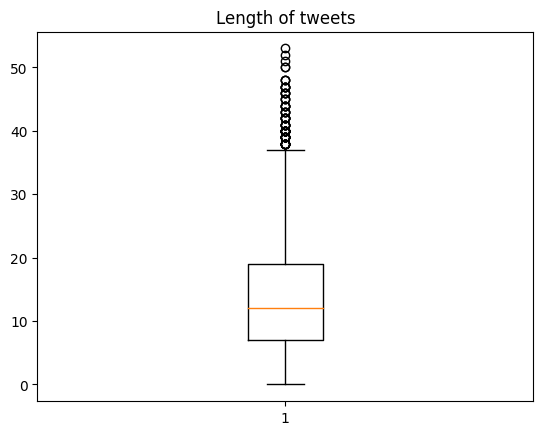

In [21]:
plt.boxplot(tweet_lens)
plt.title('Length of tweets')
plt.show()

In [22]:
print('Max Length: ' + str(max_len))

Max Length: 53


In [23]:
print('Average length: ' + str(sum(tweet_lens)/len(tweet_lens)))

Average length: 13.22330375


In [24]:
for i in range(len(dataset[:, 1])):
    dataset[i, 1] = np.pad(dataset[i, 1], (max_len - len(dataset[i, 1]), 0), 'constant')

In [25]:
dataset[0,1]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0, 87823,
        5313, 83012, 71268,     1, 11253, 93112, 74954, 33605, 20152,
       12877, 58352, 83216, 20192, 84039, 22952, 41277, 19577])

In [26]:
dataset[:, 0][800000:] = 1

In [27]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(dataset[:, 1], dataset[:, 0], test_size = 0.10, random_state=1)
y_train = np.int32(y_train)
y_test = np.int32(y_test)

In [28]:
y_train.shape

(1440000,)

In [29]:
y_train = y_train.reshape(y_train.shape[0], 1)
y_test = y_test.reshape(y_test.shape[0], 1)

In [30]:
x_test_data = []
for x in x_test:
    x_test_data.append([k for k in x])
x_test_data = np.asarray(x_test_data)
x_test_data.shape

(160000, 53)

In [31]:
x_train_data = []
for x in x_train:
    x_train_data.append([k for k in x])
x_train_data = np.asarray(x_train_data)
x_train_data.shape

(1440000, 53)

In [32]:
emb_len = embedding_matrix.shape[1]
vocab_size = embedding_matrix.shape[0]
emb_len

300

# The Attention Model

The attention model is a sequential model similar to an RNN. However, instead of using recurrent layers to provide information of the order of a sequence, this will use the attention mechanism which will provide information as to which information is important to other information in the sequence. The key, query and value transformations will tell the model what information it should draw its attention to for each input in the sequence. This a approach solves one of the main issues with RNN's; long range dependencies. RNN's are very bad at remembering information much ealier in the sequence due to exploding and vanishing gradients, GRU's and LSTM's help with this but are not perfect as it forces the model to compress all the information it has learned into memory cells.

![Multi-Head](assets/multi-head.png)

In [33]:
n_head = 6
n_layer = 6
dropout = 0.2
batch_size = 512
block_size = max_len
lr = 1e-4

In [34]:
class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(emb_len, head_size, bias=False)
        self.query = nn.Linear(emb_len, head_size, bias=False)
        self.value = nn.Linear(emb_len, head_size, bias=False)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)   #B, T, C
        q = self.query(x) #B, T, C
        wei = q @ k.transpose(-2, -1) * C**-0.5 #(B, T, C) * (B, C, t) -> (B, T, T)
        wei = F.softmax(wei, dim=-1) #(B,T, T)
        wei = self.dropout(wei)
        v = self.value(x) #(B, T, C)
        out = wei @ v #(B, T, T) * (B, T, C) -> (B, T, C)
        return out

In [35]:
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(emb_len, emb_len)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

In [36]:
class FeedForward(nn.Module):
    def __init__(self, emb_len):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(emb_len, emb_len*4),
            nn.ReLU(),
            nn.Linear(emb_len*4, emb_len),
            nn.Dropout(dropout)
        )
        
    def forward(self, x):
        x = self.net(x)
        return x

In [37]:
class Block(nn.Module):
    def __init__(self, emb_len, n_head):
        super().__init__()
        
        head_size = emb_len // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(emb_len)
        self.ln1 = nn.LayerNorm(emb_len)
        self.ln2 = nn.LayerNorm(emb_len)
        
    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        
        return x

In [38]:
class AttentionModel(nn.Module):
    def __init__(self, embeddings):
        super().__init__()
        
        self.word_embs_table = nn.Embedding(vocab_size, emb_len)
        self.word_embs_table.load_state_dict({'weight': embeddings})
        self.word_embs_table.weight.requires_grad = False
        self.pos_embs_table = nn.Embedding(max_len, emb_len)
        self.blocks = nn.Sequential(*[Block(emb_len, n_head=n_head) for _ in range(n_layer)])
        #self.block = Block(emb_len, n_head=1)
        self.ln_f = nn.LayerNorm(emb_len)
        self.lm_head = nn.Linear(emb_len, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, idx):
        B, T = idx.shape
        word_embs = self.word_embs_table(idx)
        pos_embs = self.pos_embs_table(torch.arange(T).to(device))
        x = word_embs + pos_embs
        x = self.blocks(x) #(B, T, C)
        x = self.ln_f(x) #(B, T, C)
        x = self.lm_head(x) #(B, T, 1)
        x = x[:, -1, :]
        output = self.sigmoid(x)
        return output
        

In [39]:
from torch.utils.data import DataLoader, Dataset

class CustomDataset(Dataset):
    def __init__(self, examples, labels):
        self.examples = examples
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        example = torch.IntTensor(self.examples[idx])
        label = self.labels[idx]
        
        return example, label

In [40]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = AttentionModel(torch.tensor(embedding_matrix)).to(device)

In [41]:
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
criterion = nn.BCELoss()

In [42]:
train_dataset = CustomDataset(x_train_data, y_train)
test_dataset = CustomDataset(x_test_data, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [43]:
def train(epochs):
    for epoch in range(epochs):
        for i, (batch, labels) in enumerate(train_dataloader):
            batch, labels = batch.to(device), labels.to(device)
            labels = labels.reshape((len(labels), 1))
            labels = labels.float()
            
            model.zero_grad()
            
            output = model(batch)
            loss = criterion(output, labels)
            
            loss.backward()
            optimizer.step()
            if i % 500 == 0:
                print(f'step: {i} Loss: {loss}')

In [44]:
train(4)

step: 0 Loss: 0.7563766241073608
step: 500 Loss: 0.501509428024292
step: 1000 Loss: 0.4932723045349121
step: 1500 Loss: 0.5301410555839539
step: 2000 Loss: 0.5011727809906006
step: 2500 Loss: 0.44999879598617554
step: 0 Loss: 0.4715435206890106
step: 500 Loss: 0.46323445439338684
step: 1000 Loss: 0.43261095881462097
step: 1500 Loss: 0.49384981393814087
step: 2000 Loss: 0.4534715712070465
step: 2500 Loss: 0.4131383001804352
step: 0 Loss: 0.4481344521045685
step: 500 Loss: 0.43677812814712524
step: 1000 Loss: 0.42236658930778503
step: 1500 Loss: 0.4813661575317383
step: 2000 Loss: 0.4298541247844696
step: 2500 Loss: 0.4100232720375061
step: 0 Loss: 0.4332115948200226
step: 500 Loss: 0.41351747512817383
step: 1000 Loss: 0.4022032916545868
step: 1500 Loss: 0.4608456492424011
step: 2000 Loss: 0.39795470237731934
step: 2500 Loss: 0.38992756605148315


In [45]:
print(sum(p.numel() for p in model.parameters())/1e6, 'Million parameters')

34.656901 Million parameters


In [46]:
def print_accuracy(dataloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for messages, labels in dataloader:
            messages = torch.tensor(messages).to(device)
            outputs = model(messages)
            outputs = outputs.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            outputs = outputs >= 0.5
            labels = labels == 1.0
            total += len(labels)
            for i in range(len(labels)):
                if labels[i] == outputs[i][0]:
                    correct += 1
    print(correct / total)

In [47]:
print_accuracy(test_dataloader)

C:\Users\daman\AppData\Local\Temp\ipykernel_17788\3151982353.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  messages = torch.tensor(messages).to(device)


0.8038


In [48]:
print_accuracy(train_dataloader)

C:\Users\daman\AppData\Local\Temp\ipykernel_17788\3151982353.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  messages = torch.tensor(messages).to(device)


0.8073215277777778


In [49]:
#torch.save(model.state_dict(), 'sent_trans.pt')

# Results and Conclusion

This model achieved an accuracy of about 81%. Which isn't the best and I believe the reason for this is the fact I am using GloVe embeddings. GloVe embeddings are a quick and easy way to get word embeddings but I believe this model would perform a lot better if I generated my own embeddings.

In [50]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

In [51]:
def cm(dataloader):
    true_pos = 0
    true_neg = 0
    false_pos = 0
    false_neg = 0
    with torch.no_grad():
        for messages, labels in dataloader:
            messages = torch.tensor(messages).to(device)
            outputs = model(messages)
            outputs = outputs.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            outputs = outputs >= 0.5
            labels = labels == 1.0
            for i in range(len(labels)):
                if outputs[i] == True:
                    if labels[i] == True:
                        true_pos += 1
                    else:
                        false_pos += 1
                else:
                    if labels[i] == False:
                        true_neg += 1
                    else:
                        false_neg += 1
    return np.asarray([[true_neg, false_neg], [false_pos, true_pos]])

In [52]:
cm_ = cm(test_dataloader)

C:\Users\daman\AppData\Local\Temp\ipykernel_17788\1465458185.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  messages = torch.tensor(messages).to(device)


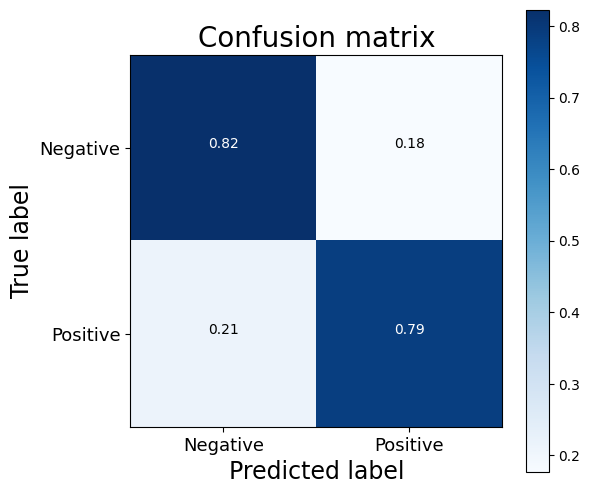

In [53]:
cnf_matrix = np.asarray(cm_)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=['Negative', 'Positive'], title="Confusion matrix")
plt.show()